In [4]:
!pip install labelme opencv-python matplotlib albumentations

In [5]:
import os
import time
import uuid
import cv2

In [6]:
uuid.uuid1()

UUID('45d3dbd3-3559-11f0-ad26-b1dad3beccfd')

In [7]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [8]:
#Doing this to find my Video Capture number
def find_cameras(max_tested=5):
    for i in range(max_tested):
        cap = cv2.VideoCapture(i)
        if cap.read()[0]:
            print(f"Camera found at index: {i}")
            cap.release()
        else:
            print(f"No camera at index: {i}")

find_cameras()

Camera found at index: 0
No camera at index: 1
No camera at index: 2
No camera at index: 3
No camera at index: 4


In [10]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting the images {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [13]:
!labelme

2025-05-19 16:16:44.772 | INFO     | labelme.config:get_config:66 - Loading config file from: C:\Users\shrey\.labelmerc


In [9]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

### Limiting the GPU growth

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.configure.experimental.set_memory_growth(gpu, True)

In [11]:
tf.test.is_gpu_available()

False

### Loading Images

In [12]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)

In [14]:
#Need to get this part for the path checking
images.as_numpy_iterator().next()

b'data\\images\\0e57955b-349e-11f0-b04e-b1dad3beccfd.jpg'

In [15]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [16]:
images = images.map(load_image)

In [17]:
images.as_numpy_iterator().next()

array([[[168, 168, 142],
        [168, 168, 142],
        [166, 168, 146],
        ...,
        [163, 121,  81],
        [165, 120,  81],
        [165, 120,  81]],

       [[168, 168, 144],
        [168, 168, 144],
        [169, 168, 147],
        ...,
        [162, 123,  84],
        [164, 122,  84],
        [165, 121,  84]],

       [[169, 167, 146],
        [168, 167, 146],
        [169, 168, 148],
        ...,
        [158, 122,  86],
        [160, 122,  86],
        [160, 122,  86]],

       ...,

       [[151, 153, 148],
        [152, 154, 149],
        [152, 157, 150],
        ...,
        [131, 122,  67],
        [131, 122,  67],
        [132, 123,  68]],

       [[146, 151, 145],
        [147, 152, 146],
        [148, 153, 146],
        ...,
        [131, 122,  67],
        [131, 122,  67],
        [132, 123,  68]],

       [[147, 152, 146],
        [147, 152, 146],
        [148, 153, 146],
        ...,
        [133, 124,  69],
        [132, 123,  68],
        [134, 125,  70]]

In [18]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### Raw Images

In [20]:
#Visualize 4 images at a time
image_generator = images.batch(4).as_numpy_iterator()

In [21]:
plot_images = image_generator.next()

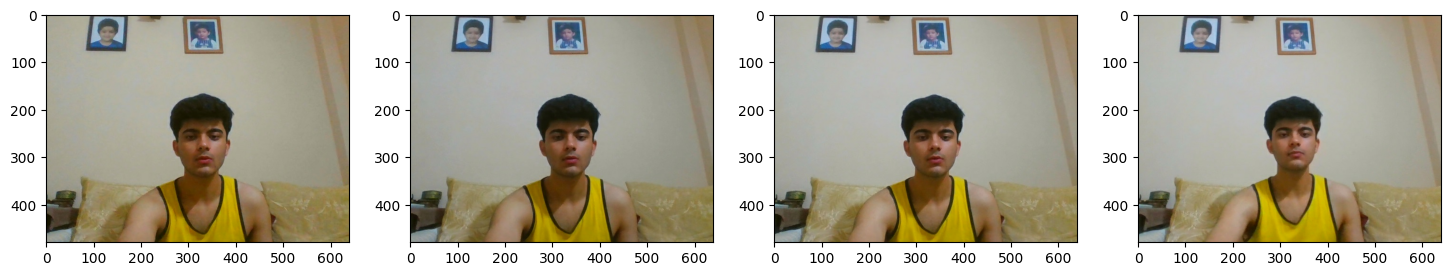

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(18,20))
for i, image in enumerate(plot_images):
    ax[i].imshow(image)
plt.show()

#### Manually splitting the data

In [23]:
#60 to train + 15 to test + 15 to validation

### Moving the matching labels

In [26]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

## Augmentation Part

In [27]:
import albumentations as alb

In [30]:
#Just checking brfore applying cropping
img = cv2.imread(os.path.join('data','train','images',
                              '1f228419-349e-11f0-9598-b1dad3beccfd.jpg'))

In [123]:
img.shape

(480, 640, 3)

In [230]:
augmentor = alb.Compose([
    alb.RandomCrop(width=410, height=410),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)],
    bbox_params=alb.BboxParams(format='albumentations',
    label_fields=['class_labels']))

#### Testing an image

In [231]:
test_img = cv2.imread(os.path.join('data','train','images', '15b0faa2-349e-11f0-9e8c-b1dad3beccfd.jpg'))

In [232]:
test_img

array([[[171, 160, 163],
        [169, 160, 163],
        [169, 161, 162],
        ...,
        [ 97, 121, 151],
        [ 96, 120, 150],
        [ 96, 120, 150]],

       [[168, 159, 162],
        [168, 159, 162],
        [165, 159, 160],
        ...,
        [ 96, 120, 150],
        [ 97, 121, 151],
        [ 97, 121, 151]],

       [[166, 159, 162],
        [165, 160, 162],
        [164, 159, 160],
        ...,
        [ 96, 120, 148],
        [ 99, 121, 149],
        [100, 122, 150]],

       ...,

       [[152, 154, 148],
        [150, 152, 146],
        [149, 151, 145],
        ...,
        [ 63, 122, 138],
        [ 61, 120, 136],
        [ 58, 118, 134]],

       [[155, 158, 149],
        [152, 155, 146],
        [150, 153, 144],
        ...,
        [ 61, 120, 136],
        [ 60, 119, 135],
        [ 59, 119, 135]],

       [[157, 161, 150],
        [154, 158, 147],
        [151, 155, 144],
        ...,
        [ 60, 119, 135],
        [ 59, 118, 134],
        [ 60, 120, 136]]

In [233]:
with open(os.path.join('data', 'train', 'labels', '15b0faa2-349e-11f0-9e8c-b1dad3beccfd.json'),'r') as f:
    label = json.load(f)

In [234]:
label['shapes']

[{'label': 'face',
  'points': [[237.35751295336792, 158.9119170984456],
   [404.1968911917099, 332.48704663212436]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None}]

In [235]:
label['shapes'][0]['points']

[[237.35751295336792, 158.9119170984456],
 [404.1968911917099, 332.48704663212436]]

### Extracting Co-ordinates

In [236]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [237]:
coords

[237.35751295336792, 158.9119170984456, 404.1968911917099, 332.48704663212436]

In [238]:
coords = list(np.divide(coords, [640,480,640,480]))

In [239]:
coords

[np.float64(0.37087111398963735),
 np.float64(0.331066493955095),
 np.float64(0.6315576424870467),
 np.float64(0.6926813471502591)]

#### Applying Augmentation

In [240]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [241]:
augmented

{'image': array([[[157, 169, 169],
         [157, 169, 169],
         [157, 169, 169],
         ...,
         [ 62,  62,  62],
         [ 65,  63,  63],
         [ 68,  63,  64]],
 
        [[157, 169, 169],
         [157, 169, 169],
         [157, 169, 169],
         ...,
         [ 68,  63,  65],
         [ 69,  62,  65],
         [ 70,  61,  64]],
 
        [[157, 169, 169],
         [157, 169, 169],
         [157, 169, 169],
         ...,
         [ 71,  66,  68],
         [ 70,  65,  67],
         [ 70,  63,  66]],
 
        ...,
 
        [[ 82, 111, 138],
         [ 82, 110, 140],
         [ 81, 110, 141],
         ...,
         [ 70, 116, 134],
         [ 73, 116, 137],
         [ 79, 122, 143]],
 
        [[ 81, 109, 139],
         [ 82, 110, 141],
         [ 81, 109, 143],
         ...,
         [ 72, 117, 138],
         [ 75, 118, 139],
         [ 78, 121, 142]],
 
        [[ 80, 110, 139],
         [ 80, 109, 140],
         [ 81, 109, 143],
         ...,
         [ 70, 115,

In [242]:
augmented['image'].shape

(410, 410, 3)

In [243]:
augmented['bboxes']

[[0.253178312720322,
  0.29734613372058405,
  0.6601036071777344,
  0.720700143023235]]

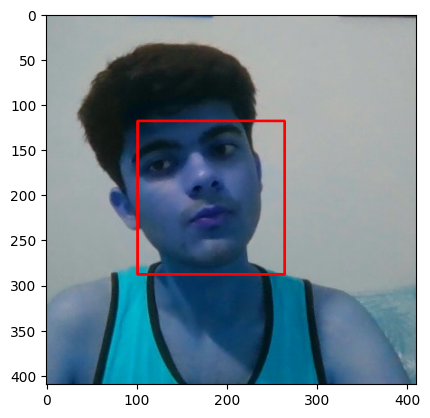

In [244]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [400,400]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [400,400]).astype(int)),
             (255,0,0), 2)

plt.imshow(augmented['image'])

## Augmentation Pipeline

In [245]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Unsupported image type: <class 'NoneType'>


### Loading augmented images to tf dataset

In [246]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [247]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [248]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [249]:
train_images.as_numpy_iterator().next()

array([[[0.53139293, 0.48170614, 0.30458876],
        [0.519424  , 0.46615604, 0.28102535],
        [0.5397059 , 0.470881  , 0.2736928 ],
        ...,
        [0.60980386, 0.5486314 , 0.39647323],
        [0.6180147 , 0.5657067 , 0.3921977 ],
        [0.617334  , 0.5663536 , 0.3929877 ]],

       [[0.5174428 , 0.47430554, 0.297018  ],
        [0.5137255 , 0.4627451 , 0.28627452],
        [0.51143795, 0.45653594, 0.27679738],
        ...,
        [0.64934635, 0.5791461 , 0.4302694 ],
        [0.60625   , 0.5380515 , 0.3740196 ],
        [0.58835804, 0.5295345 , 0.36711636]],

       [[0.53117514, 0.48019472, 0.3076457 ],
        [0.5218954 , 0.47091505, 0.298366  ],
        [0.52173203, 0.47073802, 0.30572578],
        ...,
        [0.6503407 , 0.5875956 , 0.4470658 ],
        [0.6268382 , 0.5757557 , 0.41135618],
        [0.6148963 , 0.55999434, 0.41326246]],

       ...,

       [[0.6055556 , 0.58594775, 0.5075164 ],
        [0.6184641 , 0.5913398 , 0.5205882 ],
        [0.6122412 , 0

## Preping up the Labels